In [1]:
#run patches through vae from scratch

In [2]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from particle_detection.data.data_pipeline import create_dataloaders
from particle_detection.utils.pca_preprocessing import apply_pca, plot_explained_variance

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


In [5]:
image_dir = "../data"
patch_dir = "../patches_dataset"
image_size = (128, 128)

batch_size = 128

train_patches, test_patches = create_dataloaders(data_dir=patch_dir, image_size=(128,128) , batch_size=128)
train_images, test_images = create_dataloaders(data_dir=image_dir, image_size=(2048,2048), batch_size=8)

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=256, input_channels=1):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim

        # channels 32 -> 64 -> 128 -> 256 -> 512
        # image size 64 -> 32 -> 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # dynamically compute feature map size
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 128, 128)
            encoded_output = self.encoder(dummy_input)
            self.flattened_dim = encoded_output.numel()
            self.encoded_shape = encoded_output.shape

        # latent space mapping
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # channels 256 -> 128 -> 64 -> 32 -> 1
        # image size 8 -> 16 -> 32 -> 64 -> 128
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # reparameterization trick: z = mu + std * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # encode -> reparameterize -> decode
        x = self.encoder(x).view(x.size(0), -1)

        # latent space
        mu = self.fc_mu(x)
        #logvar = torch.clamp(self.fc_logvar(x), min=-10, max=10)
        #logvar= self.fc_logvar(x)
        logvar = 10 * torch.tanh(self.fc_logvar(x))
        z = self.reparameterize(mu, logvar)

        # decode
        x = self.fc_decoder(z).view(-1, *self.encoded_shape[1:])  # Reshape back to feature map size
        x = self.decoder(x)
        return x, mu, logvar

    def encode(self, x):
        # get latent space mu
        x = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(x)


def create_vae(latent_dim=256, input_channels=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    vae = VAE(latent_dim=latent_dim, input_channels=input_channels).to(device)
    return vae

In [7]:
def train_vae(model, train_loader, optimizer, num_epochs, device="cuda"):
    model.to(device)
    model.train()

    kl_losses = []
    recon_losses = []
    total_losses = []
    
    for epoch in range(num_epochs):
        epoch_kl_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, batch in enumerate(progress_bar):
            batch = batch.to(device)

            reconstructed, mu, logvar = model(batch)
            total_loss, recon_loss, kl_loss = vae_loss(reconstructed, batch, mu, logvar, beta=5.0)

            total_loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            optimizer.zero_grad()

            epoch_kl_loss += kl_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_total_loss += total_loss.item()

            progress_bar.set_postfix(loss=f"{total_loss.item():.4f}")

        kl_losses.append(epoch_kl_loss / len(train_loader))
        recon_losses.append(epoch_recon_loss / len(train_loader))
        total_losses.append(epoch_total_loss / len(train_loader))

    print(f"Epoch {epoch+1}: Total Loss: {total_losses[-1]:.4f}, KL Loss: {kl_losses[-1]:.4f}, Recon Loss: {recon_losses[-1]:.4f}")
    
    return kl_losses, recon_losses, total_losses

In [8]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    
    recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

In [9]:
#print(vae.module.encoder)

In [10]:
vae = create_vae(latent_dim=512)
vae = nn.DataParallel(vae).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

kl_losses, recon_losses, total_losses = train_vae(model=vae, train_loader=train_patches, optimizer=optimizer, num_epochs=20, device="cuda")

Epoch 20/20: 100%|█████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s, loss=447.4570]

Epoch 20: Total Loss: 420.0029, KL Loss: 16.7921, Recon Loss: 336.0423


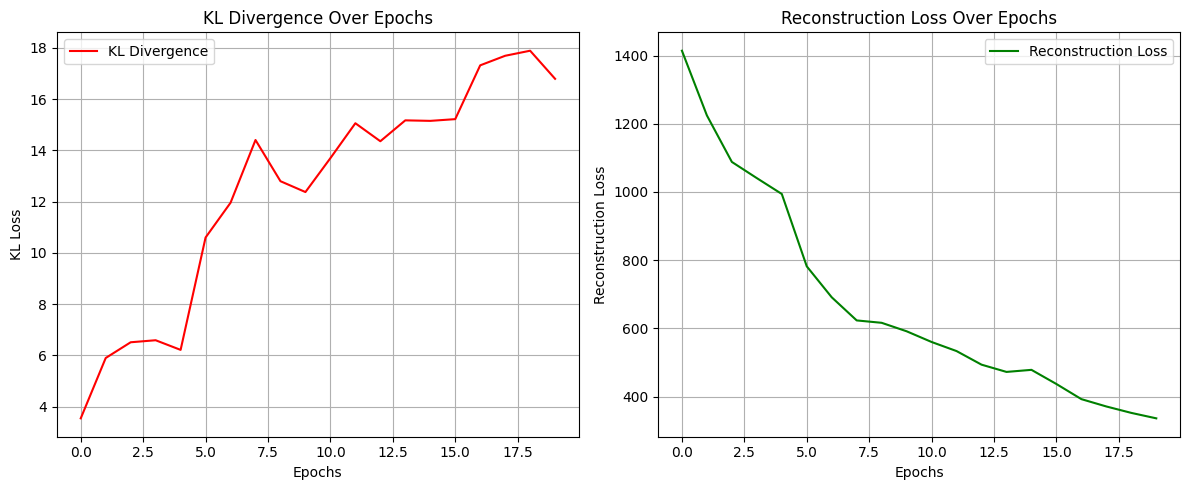

In [11]:
def plot_losses(kl_losses, recon_losses):
    
    loss_data = {
        "KL Divergence": (kl_losses, "KL Loss", "red"),
        "Reconstruction Loss": (recon_losses, "Reconstruction Loss", "green"),
    }

    fig, axes = plt.subplots(1, len(loss_data), figsize=(12, 5))  # 1 row, 2 columns

    for ax, (title, (loss_values, ylabel, color)) in zip(axes, loss_data.items()):
        ax.plot(loss_values, label=title, color=color)
        ax.set_xlabel("Epochs")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title} Over Epochs")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_losses(kl_losses, recon_losses)

In [12]:
vae.eval()
patch_size=16

In [13]:
def extract_patches(image, patch_size=16):
    
    _, channels, height, width = image.shape  
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 1, 2, 3, 4, 5).contiguous().reshape(-1, channels, patch_size, patch_size)

    return patches

In [14]:
def extract_latent_representations(data_loader, vae, patch_size=16, device="cuda", batch_size=512):
    vae.eval()
    all_latent_representations = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            batch = batch.to(device)

            for img_idx, img in enumerate(batch):
                img = img.unsqueeze(0)  # add batch dim

                patches = extract_patches(img, patch_size).to(device)

                patches = F.interpolate(patches, size=(128, 128), mode="bilinear", align_corners=False)

                latent_representations = torch.cat([
                    vae.module.encode(patches[i : i + batch_size])
                    for i in range(0, patches.shape[0], batch_size)
                ], dim=0)

                all_latent_representations.append(latent_representations)

    print(f"Processed {len(all_latent_representations)} images.")
    return all_latent_representations

In [15]:
latent_representations_per_image = extract_latent_representations(test_images, vae, patch_size=16, device="cuda")

Processed 3 images.


In [16]:
print(latent_representations_per_image[0].shape)

torch.Size([16384, 512])


In [41]:
latent_space_np = latent_representations_per_image[0].cpu().numpy()
latent_space_norm = StandardScaler().fit_transform(latent_space_np)
latent_space_pca, pca = apply_pca(latent_space_norm, n_components=50)
print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (16384, 4)


In [42]:
def visualize_clusters(img, cluster_labels, patch_size=16):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()

    height, width = img.shape[1], img.shape[2]
    clustered_image = np.zeros((height, width))

    num_patches_h = height // patch_size
    num_patches_w = width // patch_size

    # Loop through patches using grid indexing
    patch_idx = 0
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            clustered_image[i:i + patch_size, j:j + patch_size] = cluster_labels[patch_idx]
            patch_idx += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap="viridis")
    plt.colorbar()
    plt.title("Nanoparticle Clusters")
    plt.show()

    return clustered_image

In [45]:
dbscan = DBSCAN(eps=6.0, min_samples=8)
binary_cluster_labels = dbscan.fit_predict(latent_space_pca)

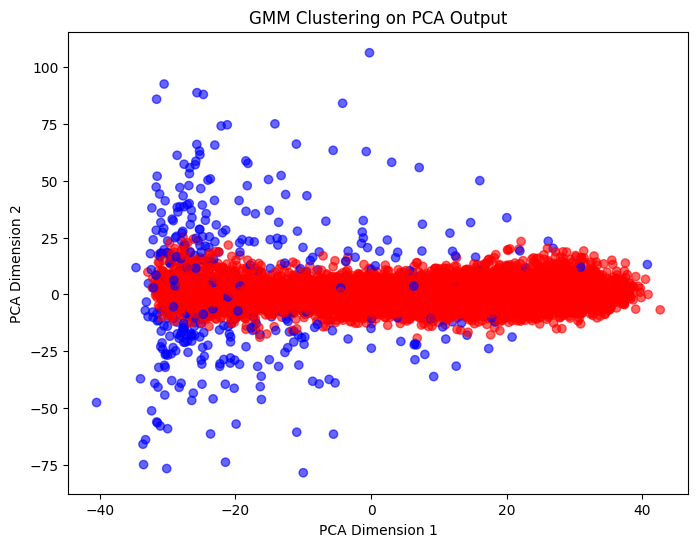

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assign colors based on cluster labels (0: Noise, 1: Particles)
colors = np.array(['red', 'blue'])  # Two distinct colors for two clusters
colored_labels = np.array(binary_cluster_labels)

# Scatter plot to visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=colors[colored_labels], alpha=0.6)
plt.title('GMM Clustering on PCA Output')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

In [47]:
test_batch = next(iter(test_images))

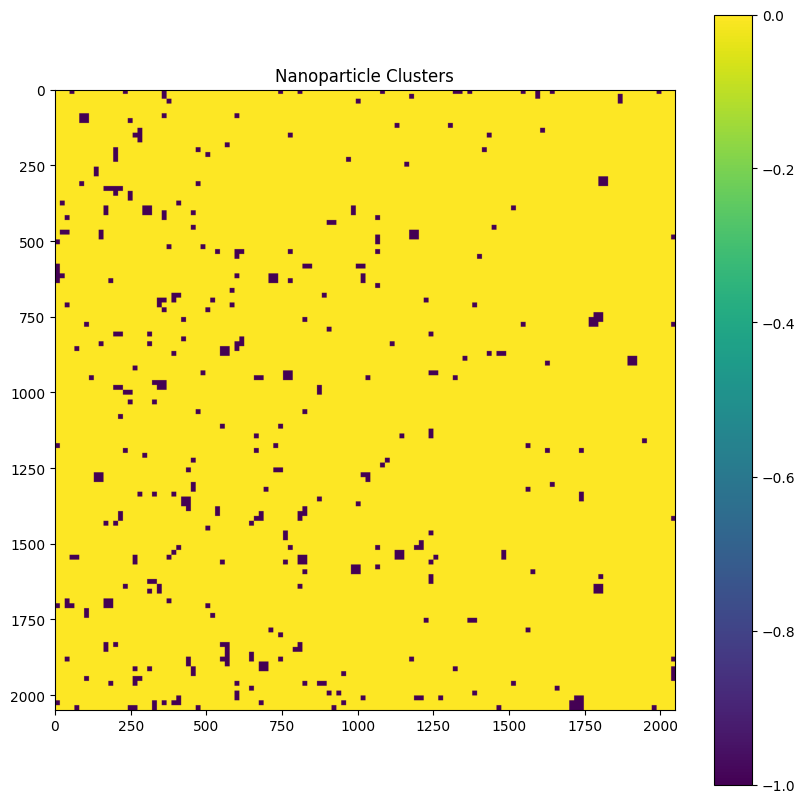

In [48]:
clustered_image = visualize_clusters(test_batch[0].cpu(), binary_cluster_labels, patch_size=16)

In [49]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def normalize_image(image):
    image = (image - image.min()) / (image.max() - image.min()) * 255
    return image.astype(np.uint8)

def label_clusters(sample_img, binary_cluster_labels, patch_size, cluster_id=None, title="Cluster Contours"):
    img_array = sample_img.cpu().numpy().squeeze()
    img_h, img_w = img_array.shape[:2]

    image_np = normalize_image(img_array)
    
    grid_h, grid_w = img_h // patch_size, img_w // patch_size
    expected_size = grid_h * grid_w

    cluster_grid = np.array(binary_cluster_labels).reshape(grid_h, grid_w)

    resized_mask = cv2.resize(cluster_grid, (img_w, img_h), interpolation=cv2.INTER_NEAREST)

    mask = (resized_mask == cluster_id).astype(np.uint8) if cluster_id is not None else (resized_mask > 0).astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    overlay = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(overlay, contours, -1, (255, 0, 0), 1)

    plt.figure(figsize=(12, 12))
    plt.imshow(overlay, cmap="gray")
    plt.title(f"Cluster {cluster_id}" if cluster_id is not None else title)
    plt.axis("off")
    plt.show()

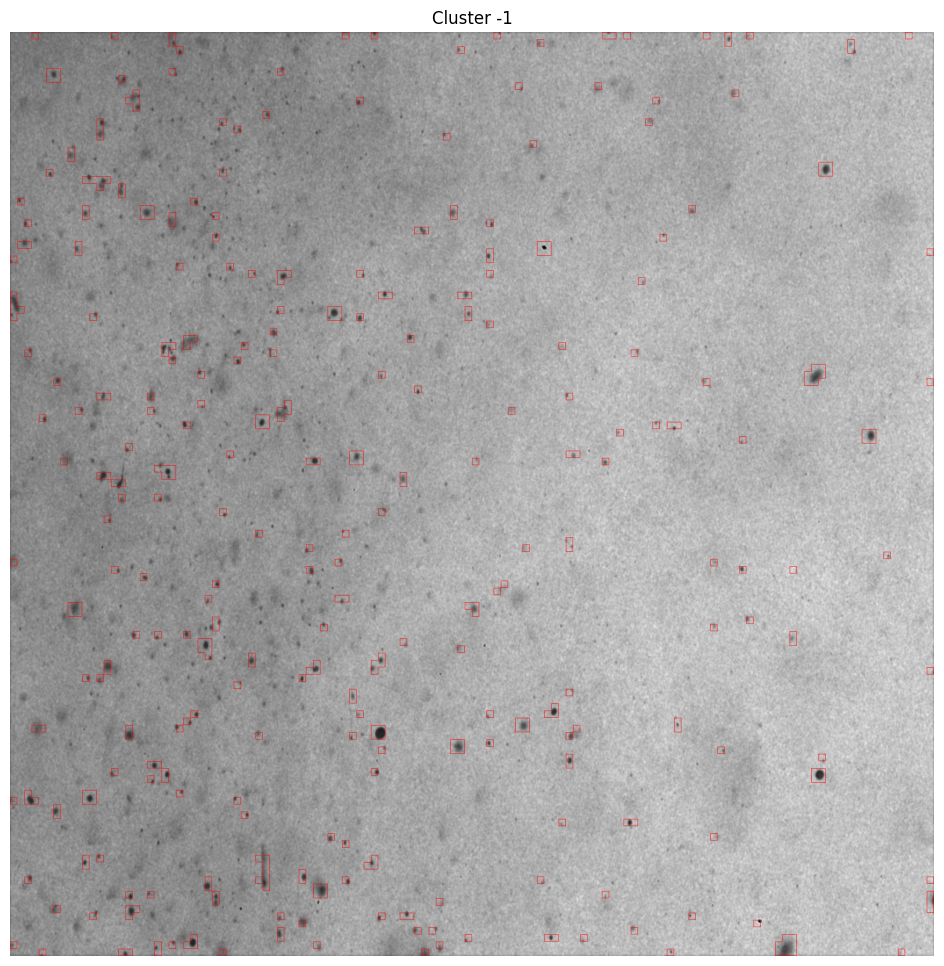

In [51]:
label_clusters(
    test_batch[0],
    binary_cluster_labels,
    patch_size,
    cluster_id=-1,
)

In [25]:
def contrastive_loss(z1, z2, y, margin=1.0):
    # z1, z2: latent vectors
    # y: 0 for similar pairs, 1 for dissimilar pairs
    euclidean_distance = F.pairwise_distance(z1, z2)
    loss = (1 - y) * torch.pow(euclidean_distance, 2) + y * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)
    return loss.mean()

In [26]:
def generate_pairs(latent_vectors):
    pairs = []
    labels = []
    for i in range(len(latent_vectors) - 1):
        z1 = latent_vectors[i]
        z2 = latent_vectors[i + 1]

        # Example: Treat consecutive patches as similar (0) or dissimilar (1)
        pairs.append((z1, z2))
        labels.append(0 if i % 2 == 0 else 1)

    return pairs, labels

In [27]:
def generate_pairs(latent_vectors, distance_threshold=1.0):
    pairs = []
    labels = []
    for i in range(len(latent_vectors) - 1):
        z1 = latent_vectors[i]
        z2 = latent_vectors[i + 1]

        # Calculate Euclidean distance
        distance = torch.norm(z1 - z2, p=2)
        
        # Treat points as similar if within the threshold
        pairs.append((z1, z2))
        labels.append(0 if distance < distance_threshold else 1)

    return pairs, labels

In [28]:
def train_vae_with_contrastive(model, train_loader, optimizer, num_epochs, device="cuda"):
    model.to(device)
    model.train()

    kl_losses = []
    recon_losses = []
    contrastive_losses = []
    total_losses = []
    
    for epoch in range(num_epochs):
        epoch_kl_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_contrastive_loss = 0.0
        epoch_total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, batch in enumerate(progress_bar):
            batch = batch.to(device)
            reconstructed, mu, logvar = model(batch)
            total_loss, recon_loss, kl_loss = vae_loss(reconstructed, batch, mu, logvar, beta=5.0)

            # Generate latent pairs and compute contrastive loss
            latent_vectors = model.module.encode(batch)
            pairs, labels = generate_pairs(latent_vectors)
            
            # Convert to tensors
            pairs = torch.stack([torch.cat([z1, z2], dim=0) for z1, z2 in pairs])
            labels = torch.tensor(labels).to(device)
            
            c_loss = contrastive_loss(pairs[:, :512], pairs[:, 512:], labels, margin=3.0)

            # Combine losses
            #final_loss = total_loss + c_loss
            final_loss = total_loss + (2.0 * c_loss)

            # Backpropagation
            final_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_kl_loss += kl_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_contrastive_loss += c_loss.item()
            epoch_total_loss += final_loss.item()

            progress_bar.set_postfix(loss=f"{final_loss.item():.4f}")

        kl_losses.append(epoch_kl_loss / len(train_loader))
        recon_losses.append(epoch_recon_loss / len(train_loader))
        contrastive_losses.append(epoch_contrastive_loss / len(train_loader))
        total_losses.append(epoch_total_loss / len(train_loader))

    return kl_losses, recon_losses, contrastive_losses, total_losses

In [29]:
vae_c_loss = create_vae(latent_dim=512)
vae_c_loss = nn.DataParallel(vae_c_loss).to(device)
optimizer_c_loss = torch.optim.Adam(vae_c_loss.parameters(), lr=1e-3)

In [30]:
kl_losses, recon_losses, contrastive_losses, total_losses = train_vae_with_contrastive(
    model=vae_c_loss, 
    train_loader=train_patches, 
    optimizer=optimizer_c_loss, 
    num_epochs=20, 
    device=device
)

Epoch 20/20: 100%|█████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.16it/s, loss=392.0699]


In [31]:
vae_c_loss.eval()

DataParallel(
  (module): VAE(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
    )
    (fc_mu): Linear(in_features=8192, out_features=512, bias=True)
    (fc_logvar): Linear(in_features=8192, out_features=512, bias=True)
    (fc_decoder): Linear(in_features=512, out_features=8192, bias=True)
    (decoder): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4

In [32]:
latent_with_c_loss = extract_latent_representations(test_images, vae_c_loss, patch_size=16, device=device)

Processed 3 images.


In [33]:
print(latent_with_c_loss[0].shape)

torch.Size([16384, 512])


In [34]:
from sklearn.preprocessing import StandardScaler

latent_space_image = latent_with_c_loss[0].cpu().numpy()
latent_space_normalized = StandardScaler().fit_transform(latent_space_image)
c_loss_pca, pca = apply_pca(latent_space_normalized, n_components=50)
print(f"Shape after PCA: {c_loss_pca.shape}")

Shape after PCA: (16384, 4)


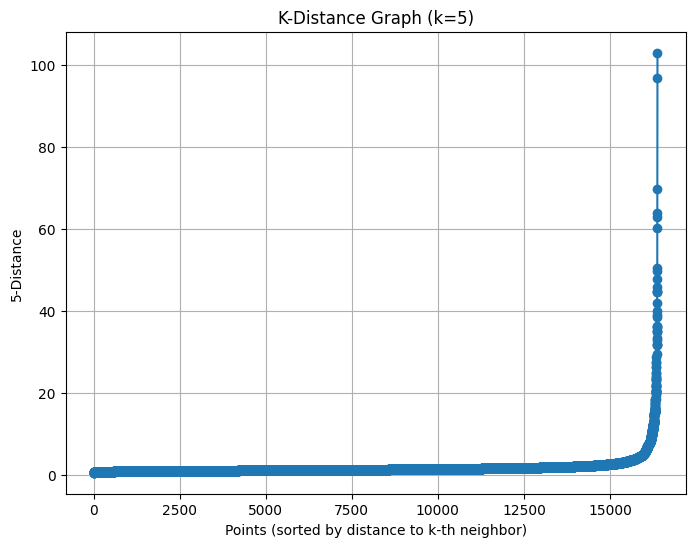

In [35]:
def plot_k_distance(data, k=5):
    """
    Plots the k-distance graph to help select the `eps` parameter for DBSCAN.
    
    Args:
        data (np.ndarray): Data for DBSCAN, shape [N, features].
        k (int): The k-th nearest neighbor to calculate distances for.
    
    Returns:
        None (plots the k-distance graph).
    """
    # Fit Nearest Neighbors model
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    
    # Find distances to the k-th nearest neighbor for each point
    distances, _ = nbrs.kneighbors(data)
    
    k_distances = np.sort(distances[:, k-1])
    
    # Plot the sorted k-distances
    plt.figure(figsize=(8, 6))
    plt.plot(k_distances, marker='o')
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Points (sorted by distance to k-th neighbor)")
    plt.ylabel(f"{k}-Distance")
    plt.grid()
    plt.show()

plot_k_distance(c_loss_pca, k=5)

In [36]:
dbscan = DBSCAN(eps=5.0, min_samples=10)
cluster_labels = dbscan.fit_predict(c_loss_pca)

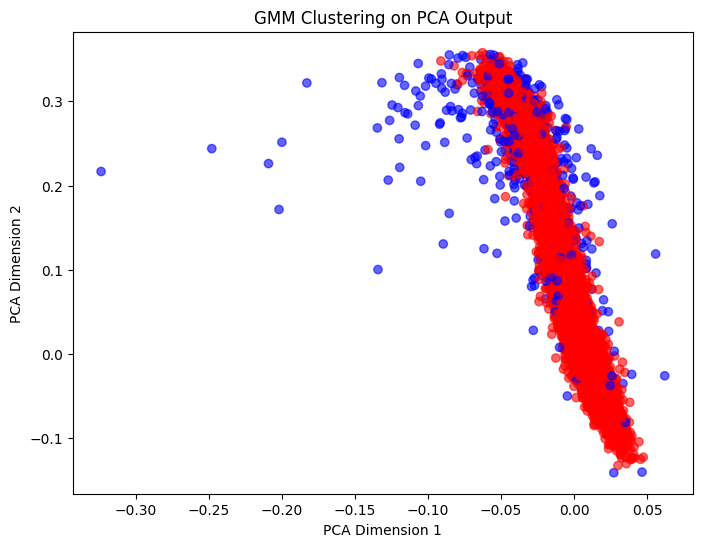

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assign colors based on cluster labels (0: Noise, 1: Particles)
colors = np.array(['red', 'blue'])  # Two distinct colors for two clusters
colored_labels = np.array(cluster_labels)

# Scatter plot to visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_image[:, 0], latent_space_image[:, 1], c=colors[colored_labels], alpha=0.6)
plt.title('GMM Clustering on PCA Output')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

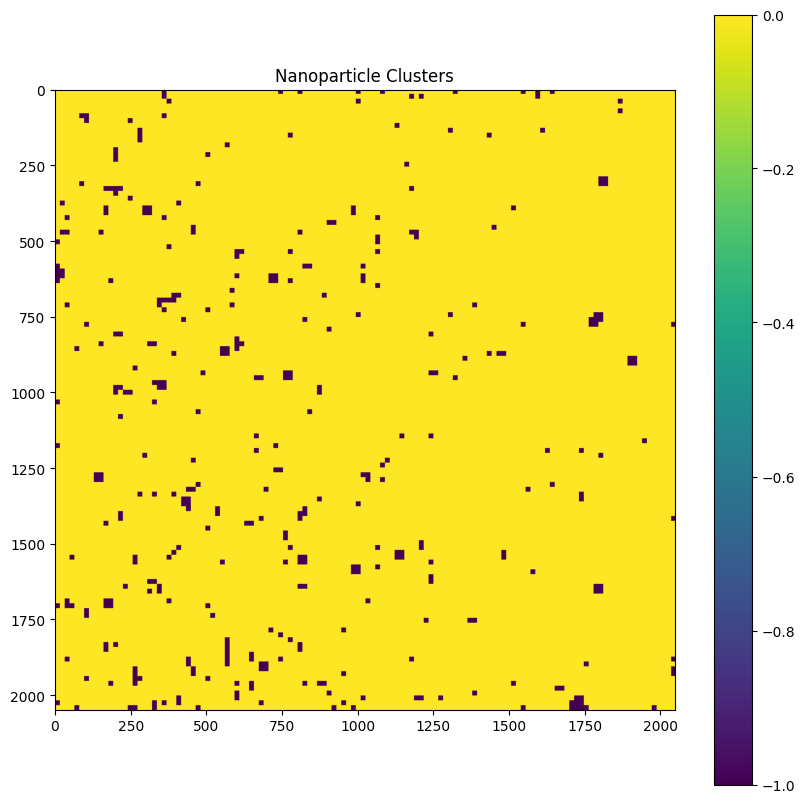

In [38]:
clustered_image = visualize_clusters(test_batch[0].cpu(), cluster_labels, patch_size=16)

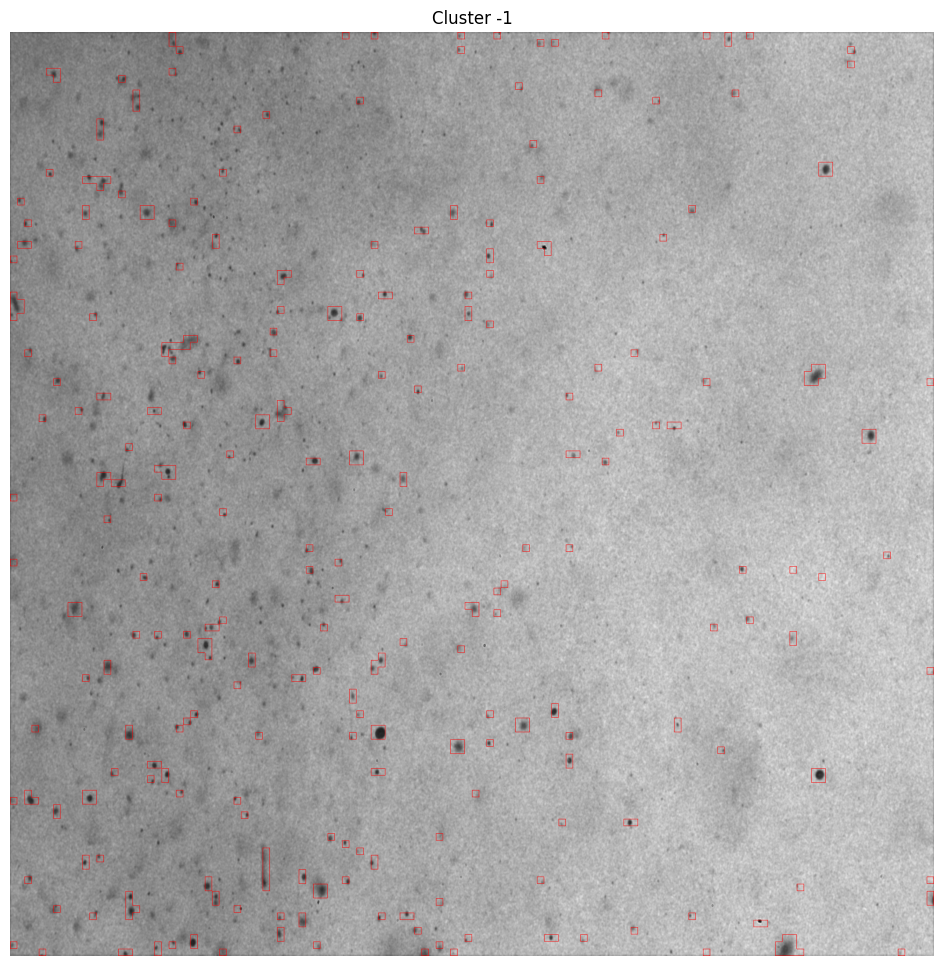

In [39]:
label_clusters(
    test_batch[0],
    cluster_labels,
    patch_size=16,
    cluster_id=-1,
)

In [40]:
from sklearn.mixture import GaussianMixture
import torch
import torch.nn.functional as F

def generate_pairs_with_gmm(latent_vectors):
    pairs = []
    labels = []
    
    # Detach and convert latent vectors to a NumPy array
    latent_vectors_np = latent_vectors.detach().cpu().numpy()

    # Run GMM clustering
    gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
    cluster_labels = gmm.fit_predict(latent_vectors_np)

    # Find the cluster with the fewest points (assuming it represents particles)
    unique_clusters = set(cluster_labels)
    particle_group_label = min(unique_clusters, key=list(cluster_labels).count)
    
    # Generate pairs based on cluster membership
    for i in range(len(latent_vectors) - 1):
        z1 = latent_vectors[i]
        z2 = latent_vectors[i + 1]
        pairs.append((z1, z2))
        
        # Treat as similar if they belong to the same cluster
        labels.append(0 if cluster_labels[i] == cluster_labels[i + 1] else 1)

    return pairs, labels

def contrastive_loss(z1, z2, y, margin=1.0):
    euclidean_distance = F.pairwise_distance(z1, z2)
    loss = (1 - y) * torch.pow(euclidean_distance, 2) + y * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)
    return loss.mean()

def train_vae_with_contrastive(model, train_loader, optimizer, num_epochs, device="cuda"):
    model.to(device)
    model.train()

    kl_losses = []
    recon_losses = []
    contrastive_losses = []
    total_losses = []
    
    for epoch in range(num_epochs):
        epoch_kl_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_contrastive_loss = 0.0
        epoch_total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, batch in enumerate(progress_bar):
            batch = batch.to(device)
            reconstructed, mu, logvar = model(batch)
            total_loss, recon_loss, kl_loss = vae_loss(reconstructed, batch, mu, logvar, beta=5.0)

            # Generate latent pairs and compute contrastive loss
            latent_vectors = model.module.encode(batch)
            pairs, labels = generate_pairs_with_gmm(latent_vectors)
            
            # Convert pairs and labels to tensors
            pairs = torch.stack([torch.cat([z1.unsqueeze(0), z2.unsqueeze(0)], dim=0) for z1, z2 in pairs])
            z1_tensor = pairs[:, 0, :]
            z2_tensor = pairs[:, 1, :]
            labels = torch.tensor(labels, dtype=torch.float32).to(device)
            
            c_loss = contrastive_loss(z1_tensor, z2_tensor, labels, margin=2.0)

            # Combine losses
            final_loss = total_loss + (2.0 * c_loss)

            # Backpropagation
            final_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_kl_loss += kl_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_contrastive_loss += c_loss.item()
            epoch_total_loss += final_loss.item()

            progress_bar.set_postfix(loss=f"{final_loss.item():.4f}")

        kl_losses.append(epoch_kl_loss / len(train_loader))
        recon_losses.append(epoch_recon_loss / len(train_loader))
        contrastive_losses.append(epoch_contrastive_loss / len(train_loader))
        total_losses.append(epoch_total_loss / len(train_loader))

    return kl_losses, recon_losses, contrastive_losses, total_losses